In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

IndentationError: unexpected indent (noise.py, line 54)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [18]:
cfg = OmegaConf.load('../config/train.yaml')

Make dataset specific changes

In [1761]:
cfg.output.project = 'MERFISH_starfish'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [1,21,21]
cfg.PSF.gauss_radii = [1.,1.8,1.8]
cfg.model.is_2D = True

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.03

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 64
cfg.training.bs = 30
cfg.noise.theta = float(3.)

cfg.roi_mask.percentile = 20
cfg.microscope.norm = 'none'
cfg.bg_estimation.smoothing.smoothing_filter_size = 4

cfg.intensity_dist.int_conc = 3.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = 1.

cfg.run_name ='MERFISH_starfish_ch0_f5'
cfg.data_path.sm_fish_ch = 0
cfg.microscope.scale = 50
cfg.bg_estimation.fractal.persistence = 0.50
cfg.bg_estimation.fractal.scale = 50

# cfg.run_name ='MERFISH_starfish_ch1_f5'
# cfg.data_path.sm_fish_ch = 1
# cfg.microscope.scale = 30
# cfg.bg_estimation.fractal.persistence = 0.50
# cfg.bg_estimation.fractal.scale = 30

In [1762]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'MERFISH_starfish_ch0_f5'

We load the image and use a simple heuristic function to estimate the noise scale. Here we use the 99% lowest intensity values
to exlude the majority of the signal. Set the percentile value to obtain a range like below. If it is to high (e.g. 99.9 in this example) you will see a long tail with high intensities, if it is to low, e.g. 95 you will get something that looks like a truncated Gaussian.

0.6589882317069946


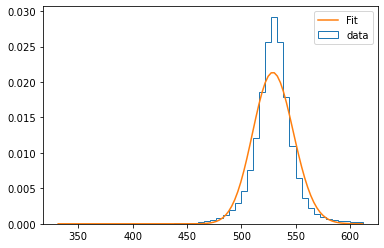

In [1745]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[cfg.data_path.sm_fish_ch][None]
bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing, device='cpu')(img)
theta = estimate_noise_scale(img, bg_est, percentile=99)
print(theta)

In [1746]:
cfg.noise.theta = float(theta)

Here we plot maximum intensity projections of the whole volume and the sub volume given by evaluation.crop_sl.  
The localizations for this sub volume are tracked during training to evaluate progress. You should chose an interesting (e.g. dense) region.

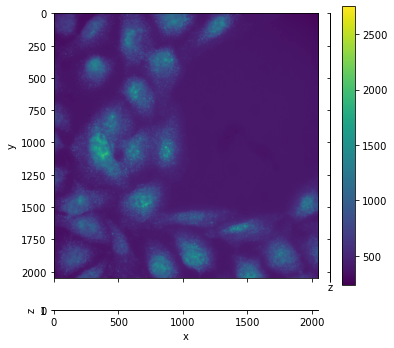

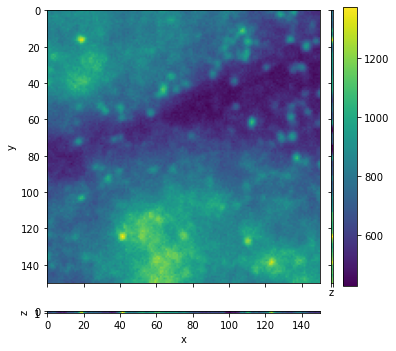

In [1747]:
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [1748]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

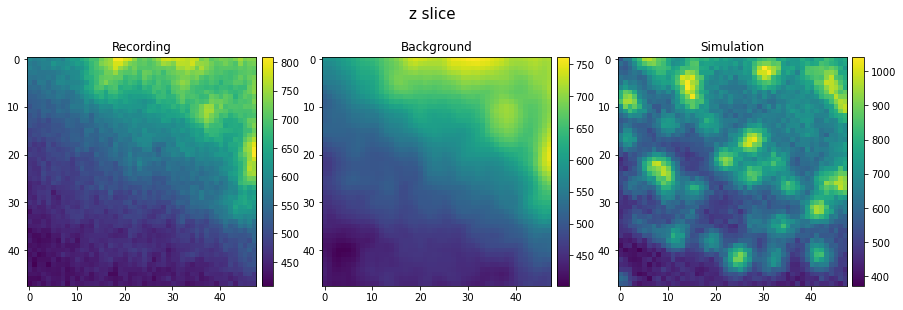

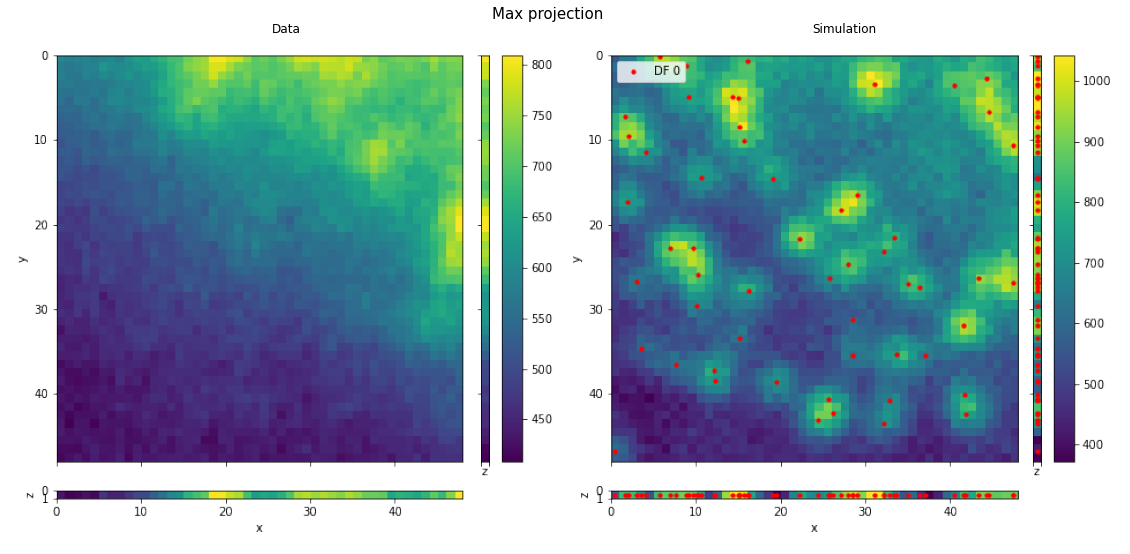

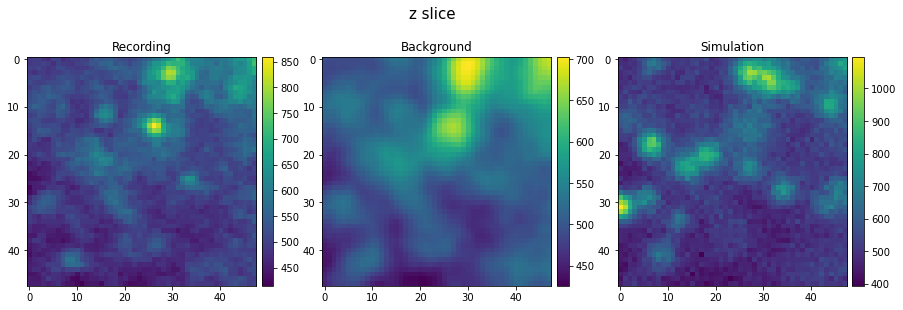

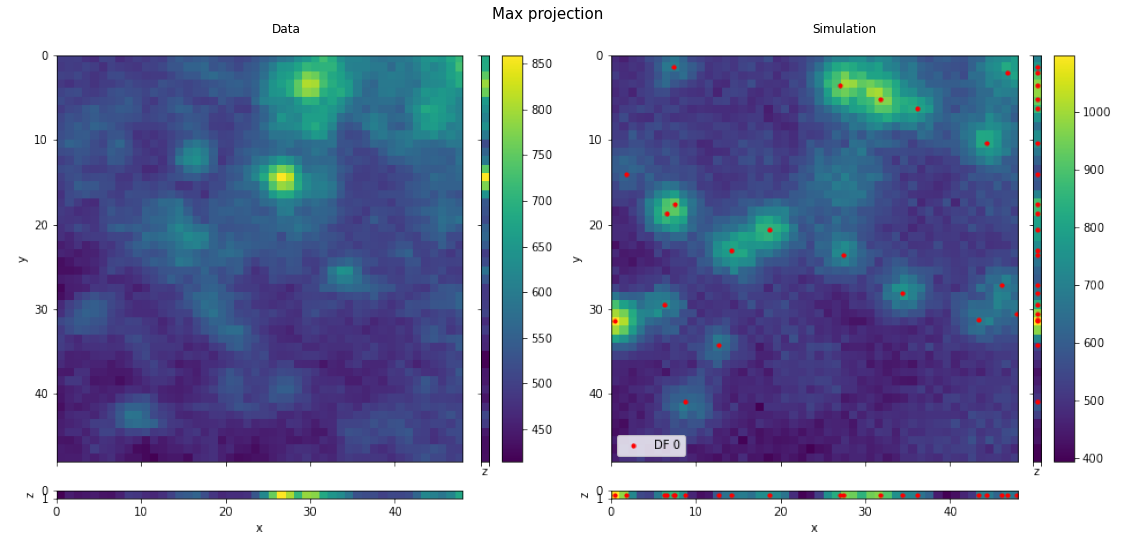

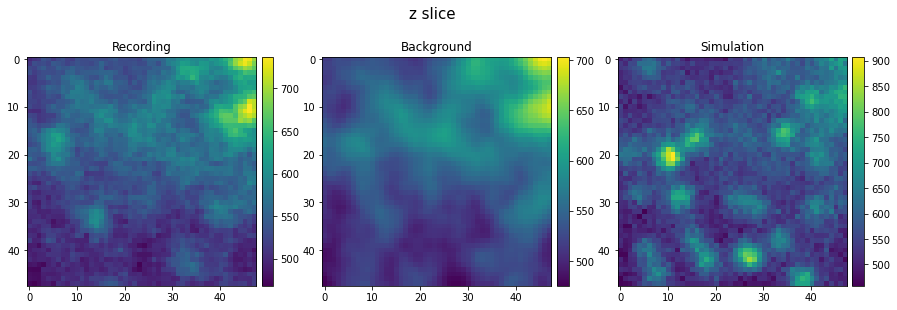

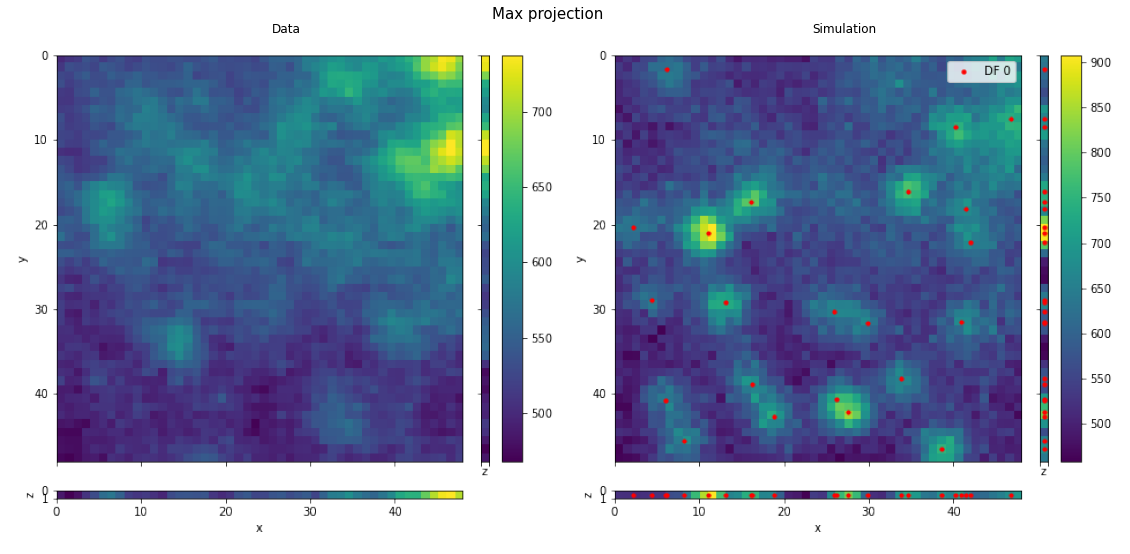

In [1749]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3)

Store the config as an experiment

In [352]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'MERFISH_starfish_ch0_f3'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training for more iterations you could execute:  
"python decode_fish/train.py +experiment=msp300_1 training.num_iters=50000 run_name=long_run"


Command to train a model on the gpu cluster

In [1710]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_starfish_ch1_f4'

# Evaluation

In [3]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch0_f2/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:7/train.yaml')

In [4]:
from omegaconf import open_dict
with open_dict(cfg):
    cfg.merfish={}
    cfg.merfish.shuffle_ch=False

In [8]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
9 volumes


In [23]:
from decode_fish.funcs.output_trafo import *
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.visualization import *

def sim_data(decode_dl, batches, micro, model):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_dfs.append(sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    return pred_df

In [24]:
xsim, gt = sim_data(decode_dl, 20, micro,model)
pred_df = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

In [25]:
perf, matches, _ = matching(px_to_nm(gt[gt['ch_idx']==0], cfg.evaluation.px_size_zyx), pred_df, tolerance=200, print_res=True)

Recall: 0.789
Precision: 0.891
Jaccard: 71.970
RMSE_vol: 71.287
Eff_3d: 54.656
FN: 4649.0 FP: 2130.0
Num. matches: 17406.000
Shift: 0.36,-0.50,0.00


0.4675160947537928


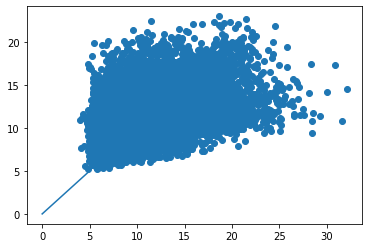

In [26]:
plt.scatter(matches['int_tar'], matches['int_pred'])
print(np.corrcoef((matches['int_tar'], matches['int_pred']))[0,1])
plt.plot([0,5],[0,5])

In [27]:
perfs_sig = []
perfs_int = []
x = np.linspace(100,50,11)
for i in x:
    sub_df = filt_perc(pred_df, perc=i, metric='comb_sig', return_low=True)
    perf, matches, _ = matching(px_to_nm(gt[gt['ch_idx']==0], cfg.evaluation.px_size_zyx), sub_df, tolerance=200, print_res=False)
    perfs_sig.append(perf)
for i in x: 
    sub_df = filt_perc(pred_df, perc=i, metric='int', return_low=False)
    perf, matches, _ = matching(px_to_nm(gt[gt['ch_idx']==0], cfg.evaluation.px_size_zyx), sub_df, tolerance=200, print_res=False)
    perfs_int.append(perf)

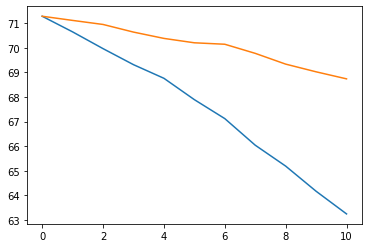

In [28]:
plt.plot([p['rmse_vol'] for p in perfs_sig])
plt.plot([p['rmse_vol'] for p in perfs_int])

Plot mean projections of the PSF before and after optimizing it during training

(tensor(0., device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))


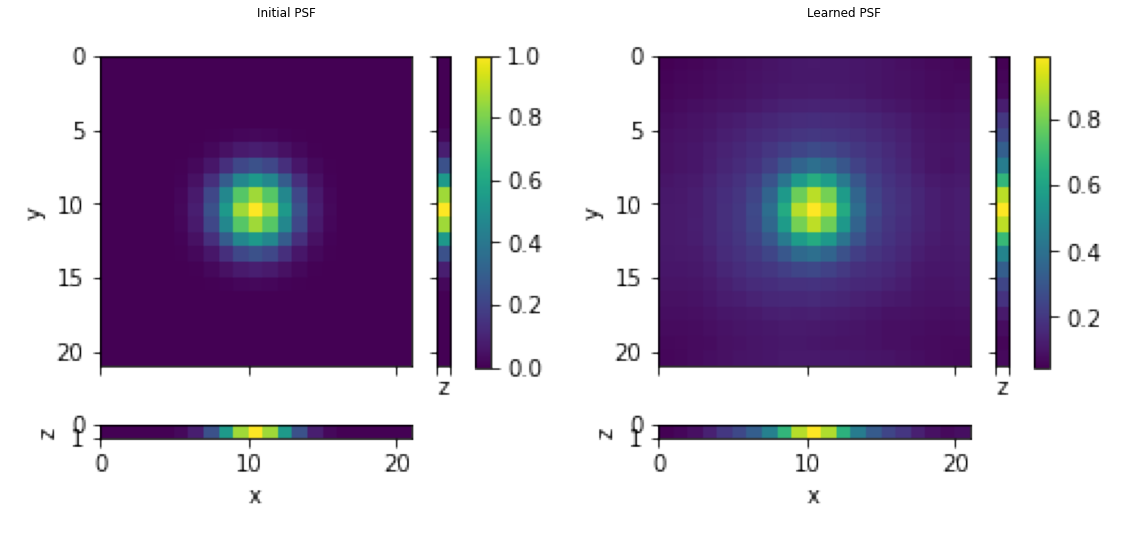

In [9]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [1897]:
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, min_int=-1000.):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        pred_df = pred_df[pred_df['int'] > min_int]

        if return_rec:
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict)[:6]
            inds = torch.where(ints_3d > min_int)[0]
            ae_img_3d = micro([l[inds] for l in locations], x_os_3d[inds], y_os_3d[inds], z_os_3d[inds], ints_3d[inds], output_shape)   
            return pred_df, ae_img_3d + res_dict['background'], res_dict
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])

            diff = abs(x-rec)
            fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
            rmse = np.sqrt(((diff)**2).mean())

            combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))

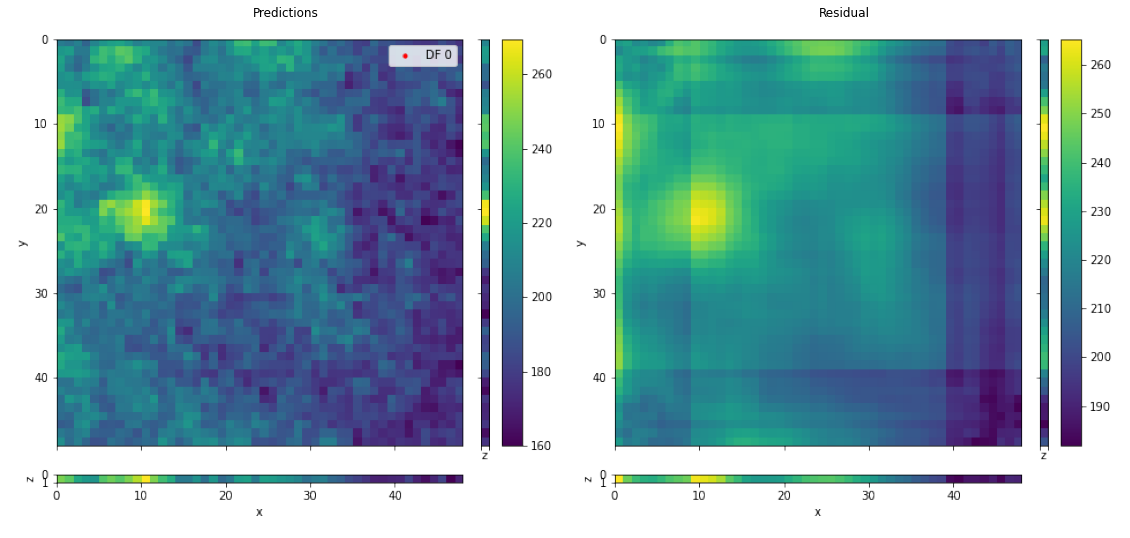

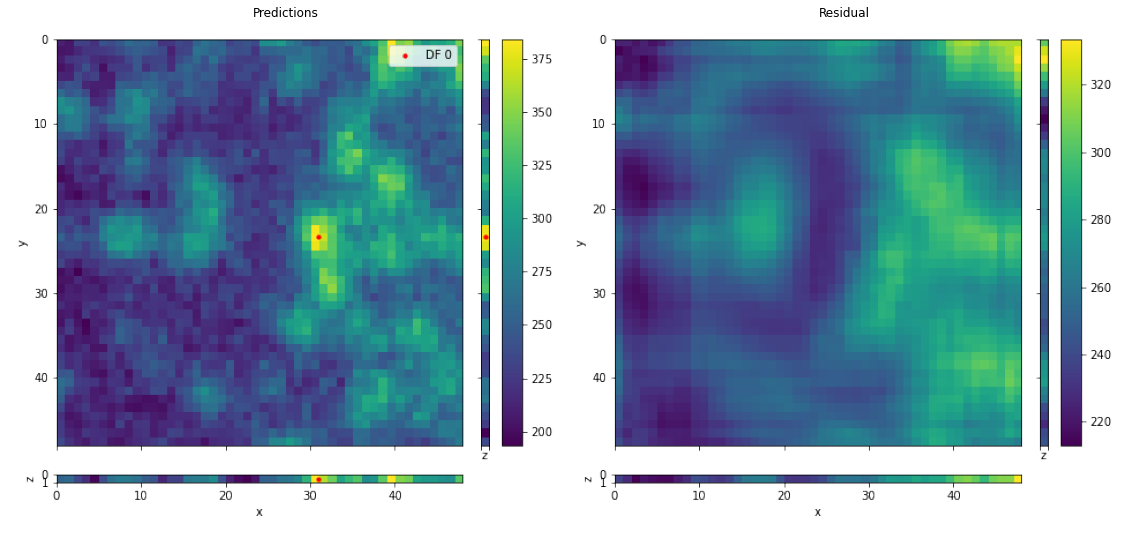

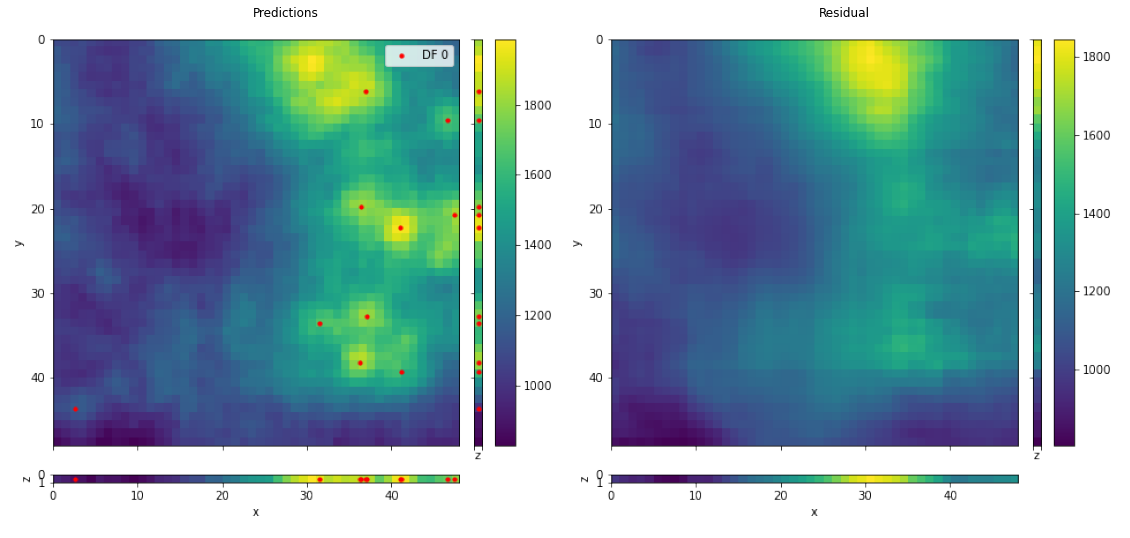

In [1898]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=3)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [1871]:
# paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_norm_3a/norm:none/train.yaml',
#          f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_norm_3b/norm:none/train.yaml']

paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch0_f4/train.yaml',
         f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/MERFISH_starfish_ch1_f4/train.yaml']

paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1a/scale:0xsmoothing_filter_size:7/train.yaml',
         f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:9/train.yaml']

# paths = [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/sweep_bg_1b/scale:0xsmoothing_filter_size:5/train.yaml']

In [1872]:
from decode_fish.funcs.predict import *
for i,p in enumerate(paths):
    cfg = OmegaConf.load(p)
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
#     post_proc.samp_threshold = 0.5
    image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/bit*.tiff'))
    inf_df = predict(model, post_proc, image_paths, sm_fish_ch=cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda')
    inf_df.to_csv(f'../data/results/MERFISH/exp_4_ch{cfg.data_path.sm_fish_ch}.csv', index=False)

  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  19871


 12%|████████▏                                                        | 1/8 [00:03<00:25,  3.61s/it]

bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  21326


 25%|████████████████▎                                                | 2/8 [00:06<00:20,  3.48s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  20713


 38%|████████████████████████▍                                        | 3/8 [00:10<00:17,  3.45s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17866


 50%|████████████████████████████████▌                                | 4/8 [00:13<00:13,  3.40s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  20427


 62%|████████████████████████████████████████▋                        | 5/8 [00:17<00:10,  3.36s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  21977


 75%|████████████████████████████████████████████████▊                | 6/8 [00:20<00:06,  3.35s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  19333


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:23<00:03,  3.34s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  36739


  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:04<00:28,  4.05s/it]

N. emitters:  23705
bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17533


 25%|████████████████▎                                                | 2/8 [00:07<00:23,  3.88s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  19165


 38%|████████████████████████▍                                        | 3/8 [00:11<00:18,  3.77s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17079


 50%|████████████████████████████████▌                                | 4/8 [00:15<00:15,  3.76s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  16728


 62%|████████████████████████████████████████▋                        | 5/8 [00:18<00:11,  3.72s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  27550


 75%|████████████████████████████████████████████████▊                | 6/8 [00:22<00:07,  3.79s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  25666


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:26<00:03,  3.90s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])
N. emitters:  17401


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.82s/it]


In [ ]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, sm_fish_ch=0, window_size=[None,128,128], device='cuda'):
    ret = []
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                ret.append(torch.sigmoid(output['logits']))
                free_mem()
        return ret

In [1867]:
# export
def predict(model, post_proc, image_paths, sm_fish_ch=0, window_size=[None,128,128], device='cuda'):
    ret = []
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                ret.append(p_si)
                free_mem()
        return ret

In [1868]:
arrs = []
for i,p in enumerate(paths):
    cfg = OmegaConf.load(p)
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
#     post_proc.samp_threshold = 0.5
    image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path).parent)+'/bit*.tiff'))
    arrs.append(predict(model, post_proc, image_paths, sm_fish_ch=cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda'))

  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:03<00:26,  3.77s/it]

bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])


 25%|████████████████▎                                                | 2/8 [00:07<00:22,  3.83s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])


 38%|████████████████████████▍                                        | 3/8 [00:11<00:19,  3.95s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])


 50%|████████████████████████████████▌                                | 4/8 [00:15<00:15,  3.94s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])


 62%|████████████████████████████████████████▋                        | 5/8 [00:20<00:12,  4.11s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])


 75%|████████████████████████████████████████████████▊                | 6/8 [00:24<00:08,  4.10s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:28<00:04,  4.03s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])


  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
8 volumes
bit_0.tiff
torch.Size([1, 1, 1, 2048, 2048])


 12%|████████▏                                                        | 1/8 [00:04<00:29,  4.21s/it]

bit_1.tiff
torch.Size([1, 1, 1, 2048, 2048])


 25%|████████████████▎                                                | 2/8 [00:08<00:24,  4.07s/it]

bit_2.tiff
torch.Size([1, 1, 1, 2048, 2048])


 38%|████████████████████████▍                                        | 3/8 [00:12<00:21,  4.23s/it]

bit_3.tiff
torch.Size([1, 1, 1, 2048, 2048])


 50%|████████████████████████████████▌                                | 4/8 [00:16<00:15,  3.95s/it]

bit_4.tiff
torch.Size([1, 1, 1, 2048, 2048])


 62%|████████████████████████████████████████▋                        | 5/8 [00:19<00:11,  3.78s/it]

bit_5.tiff
torch.Size([1, 1, 1, 2048, 2048])


 75%|████████████████████████████████████████████████▊                | 6/8 [00:23<00:07,  3.83s/it]

bit_6.tiff
torch.Size([1, 1, 1, 2048, 2048])


 88%|████████████████████████████████████████████████████████▉        | 7/8 [00:28<00:04,  4.23s/it]

bit_7.tiff
torch.Size([1, 1, 1, 2048, 2048])


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.06s/it]


(1250.0, 1750.0)

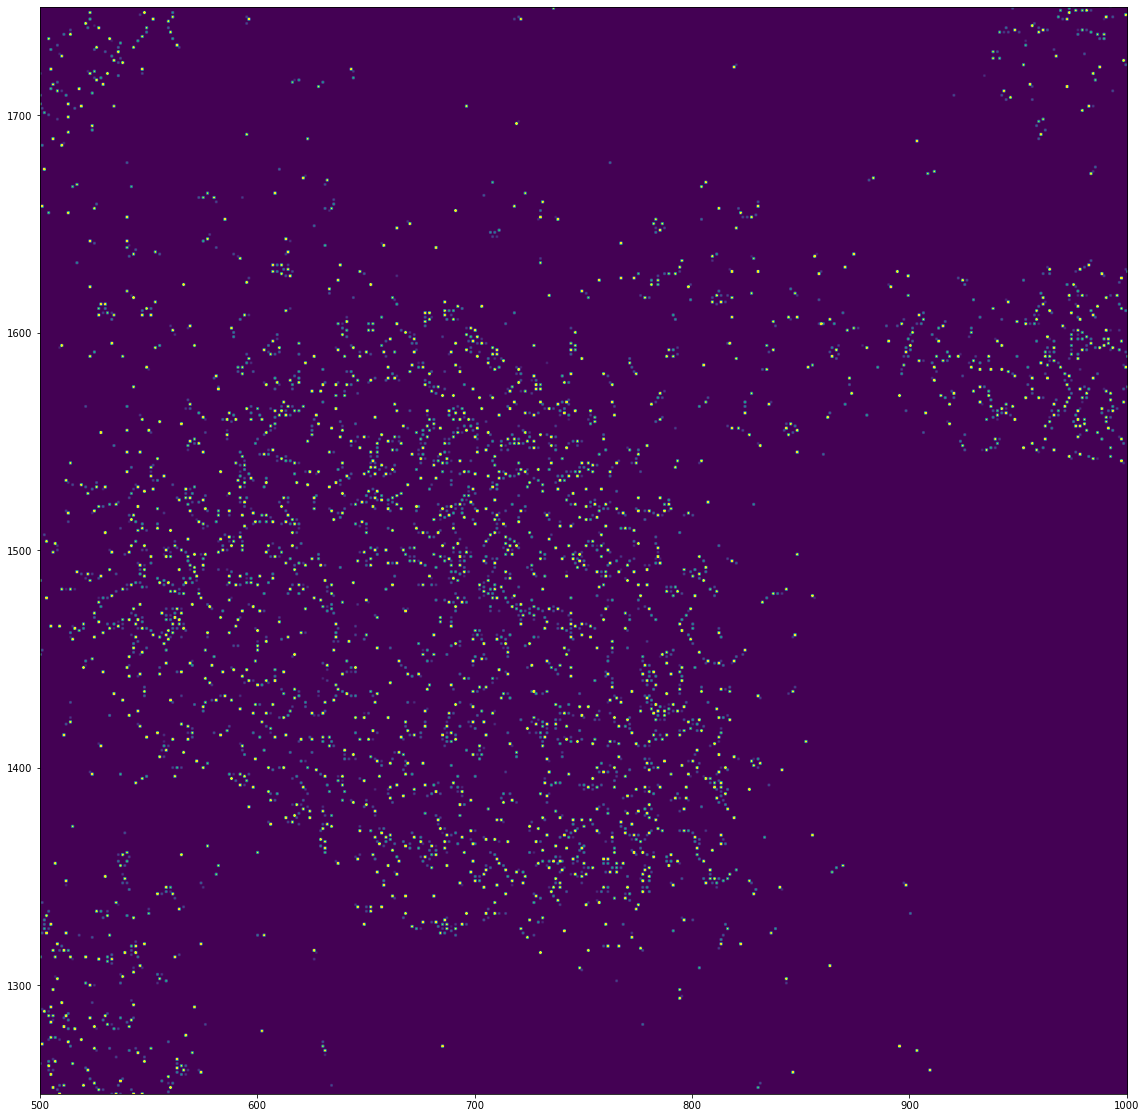

In [1869]:
plt.figure(figsize=(20,20))
plt.imshow(arrs[0][0][0][0,0],vmax=0.5)
plt.xlim(500,1000)
plt.ylim(1250,1750)

In [1870]:
np.save('../data/results/MERFISH/exp_3_pp_arr', np.stack([np.stack(arrs[0])[:,0],np.stack(arrs[1])[:,0]],1)[:,:,0])

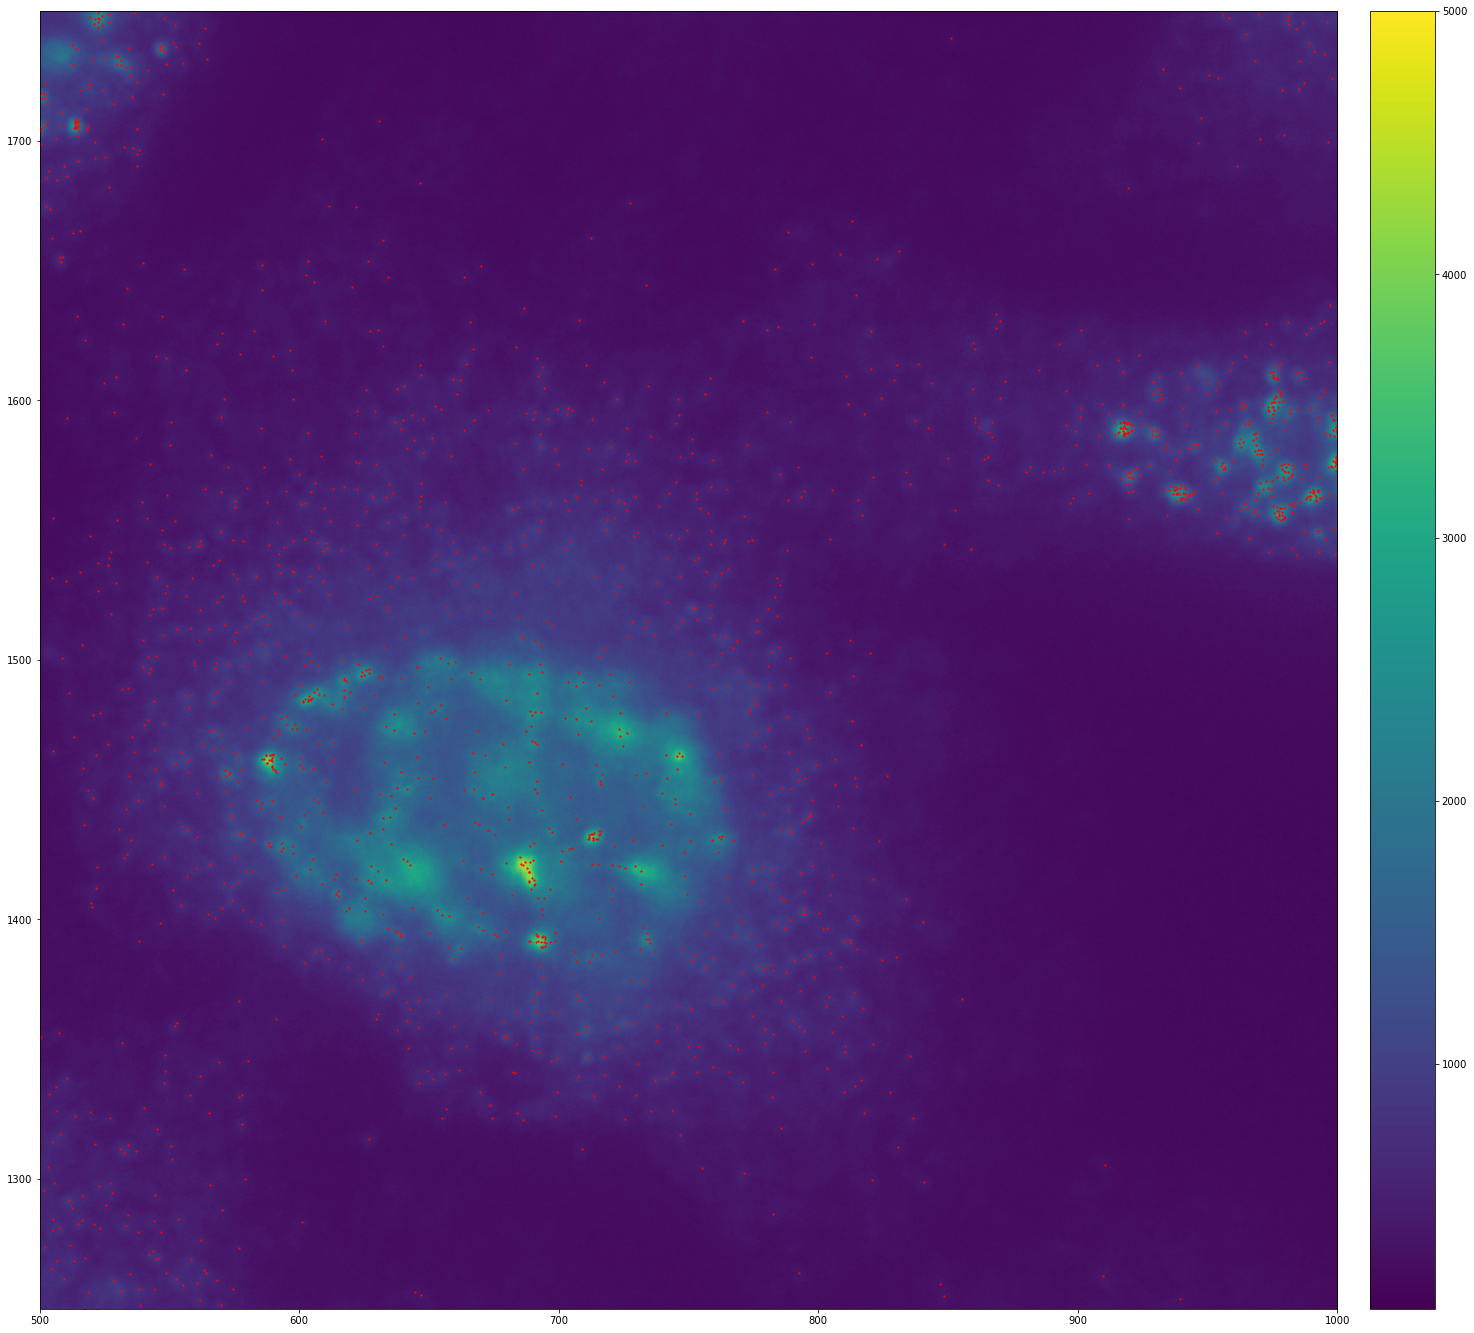

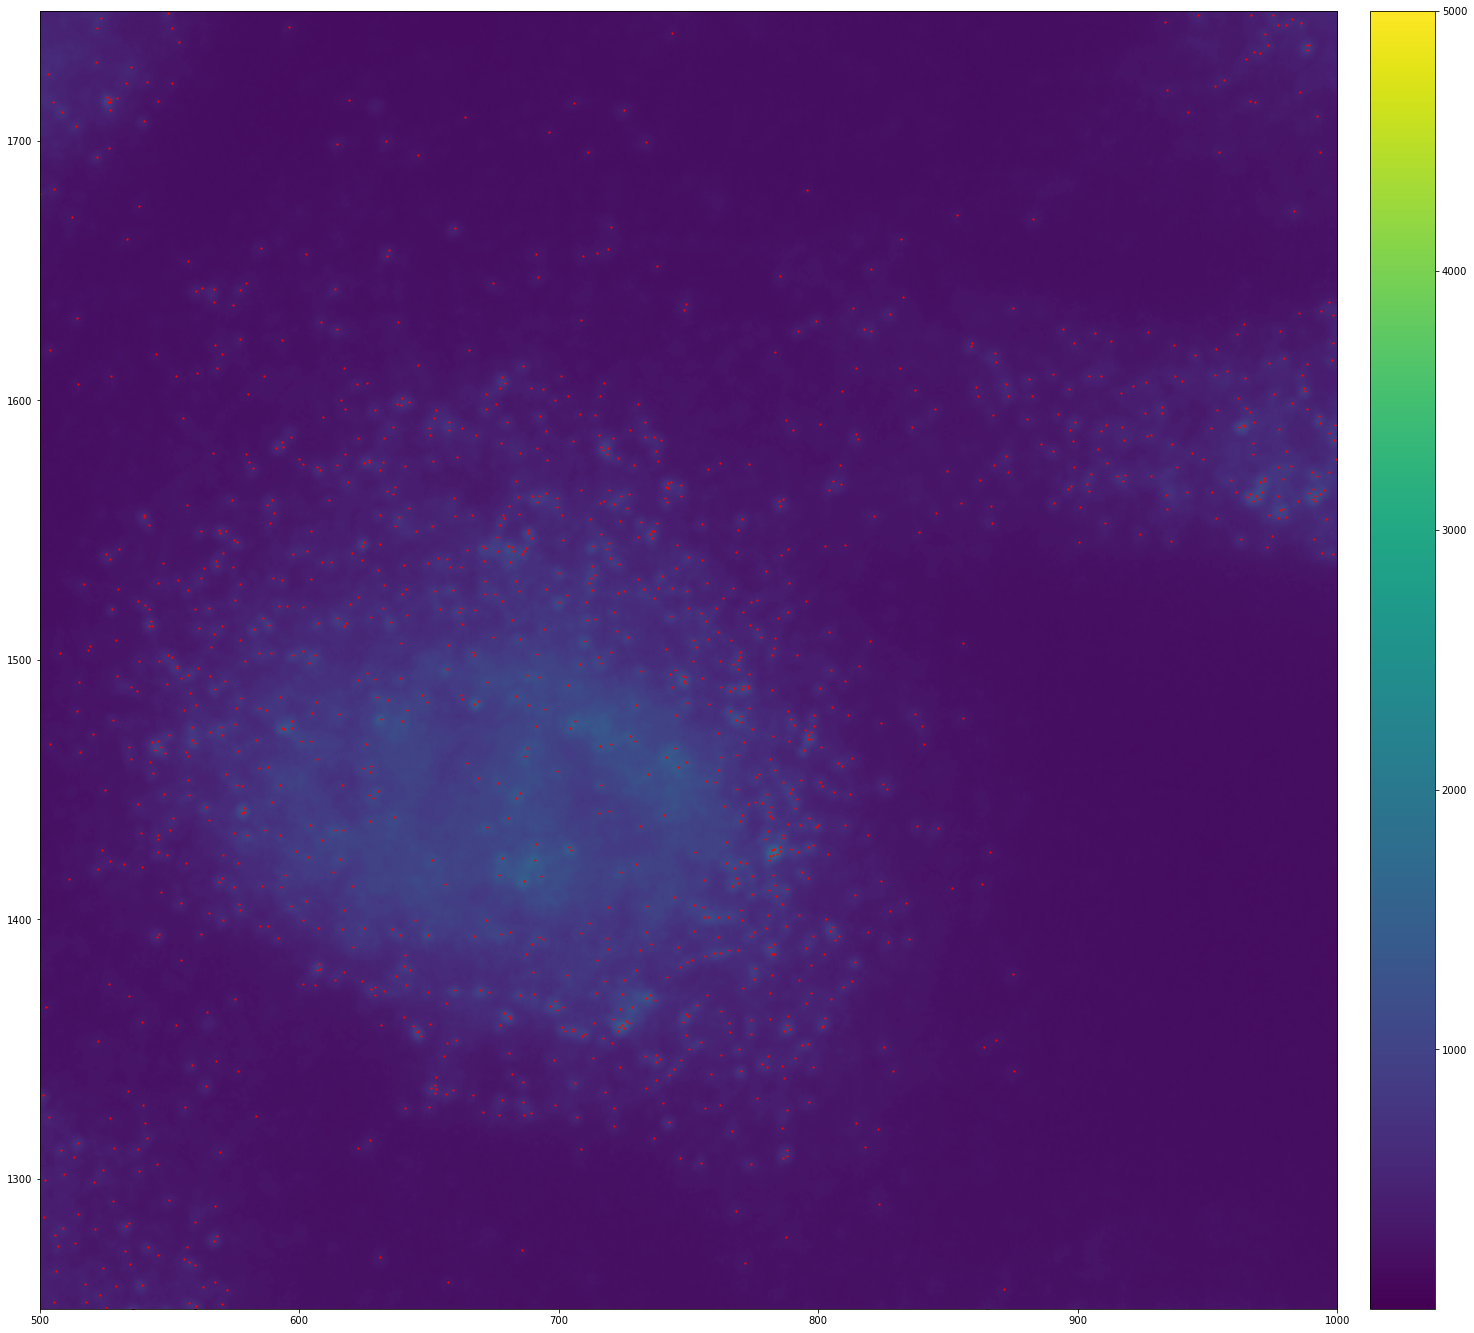

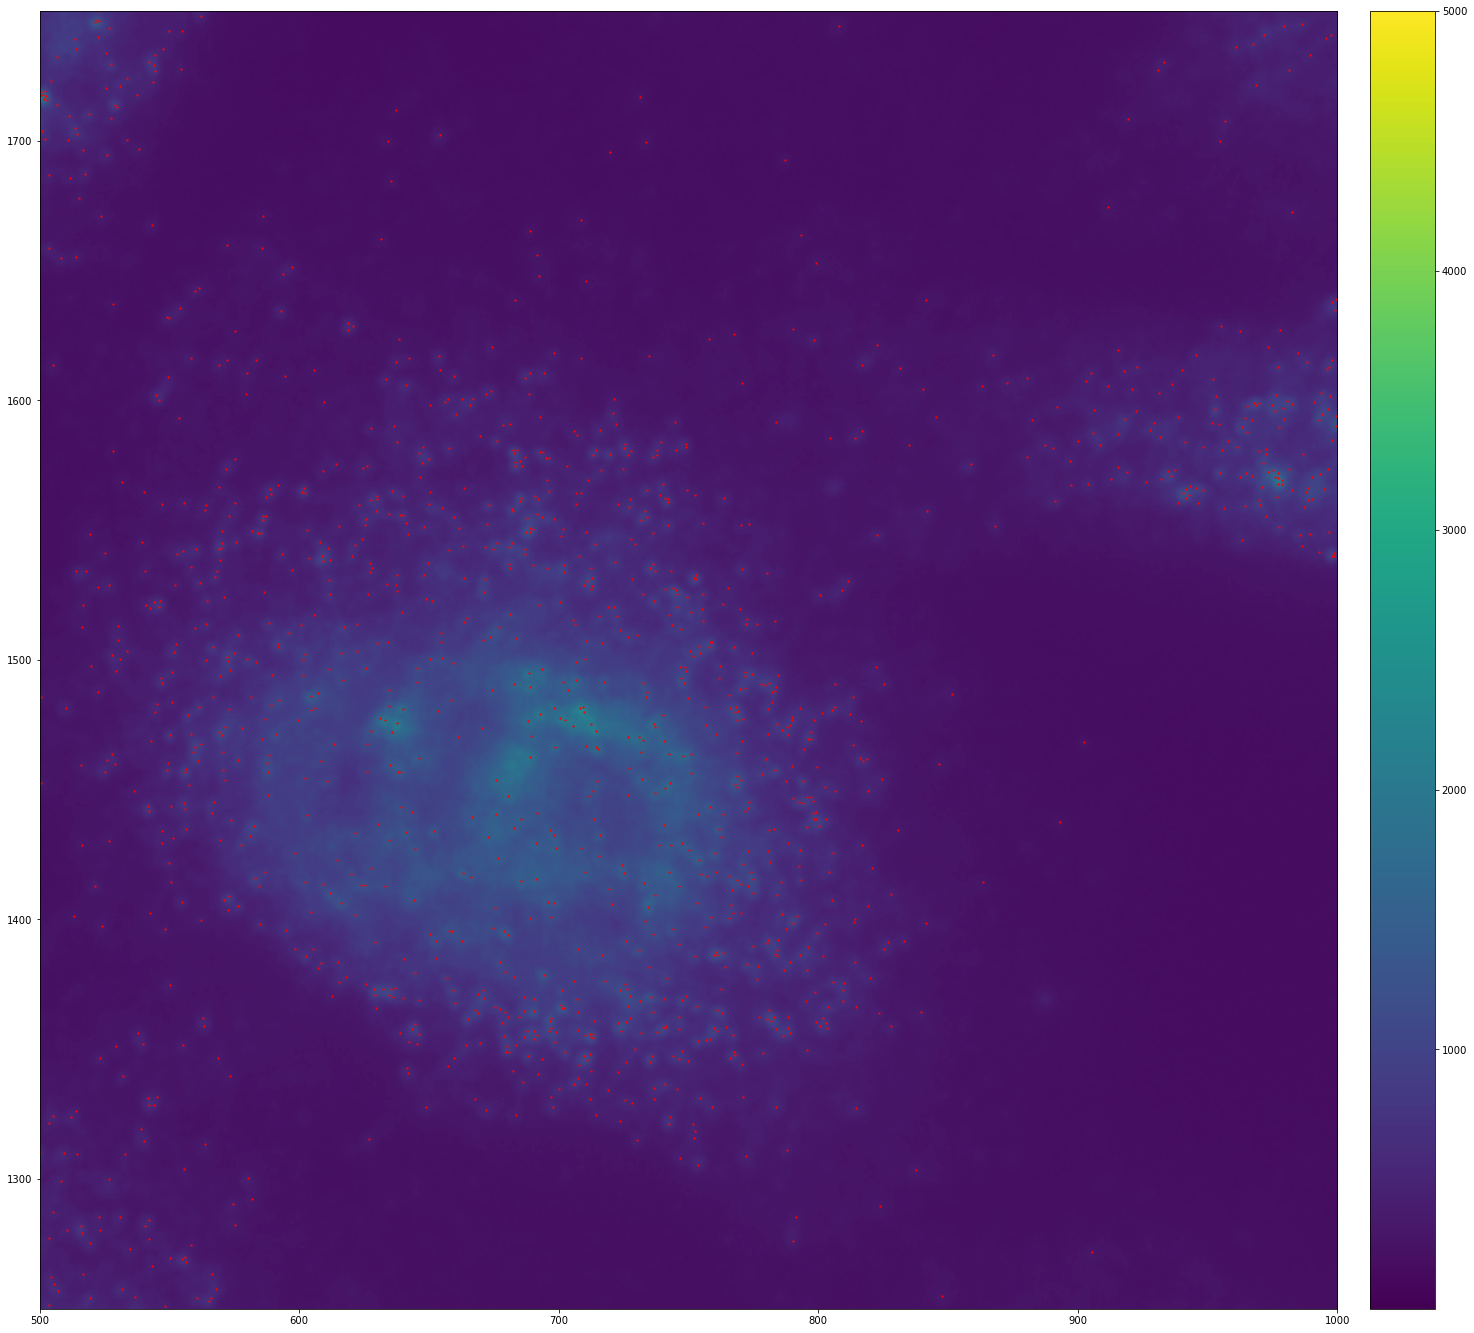

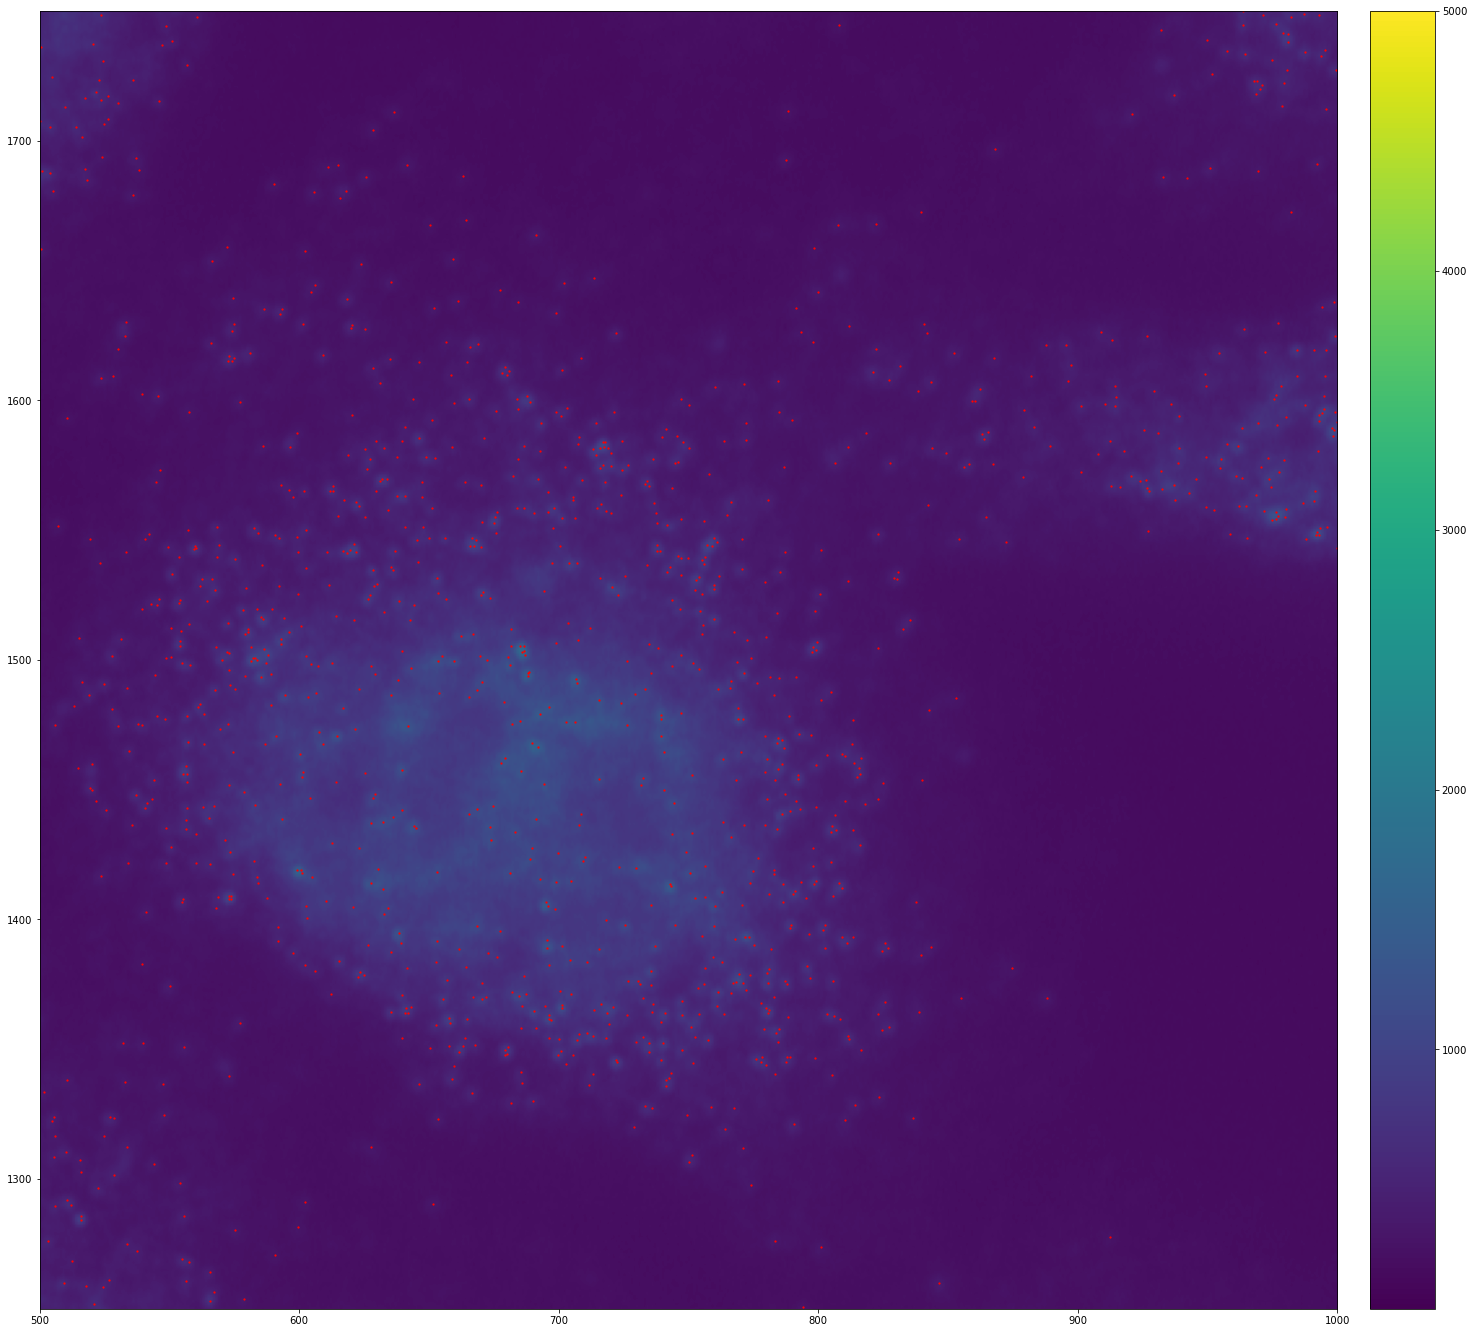

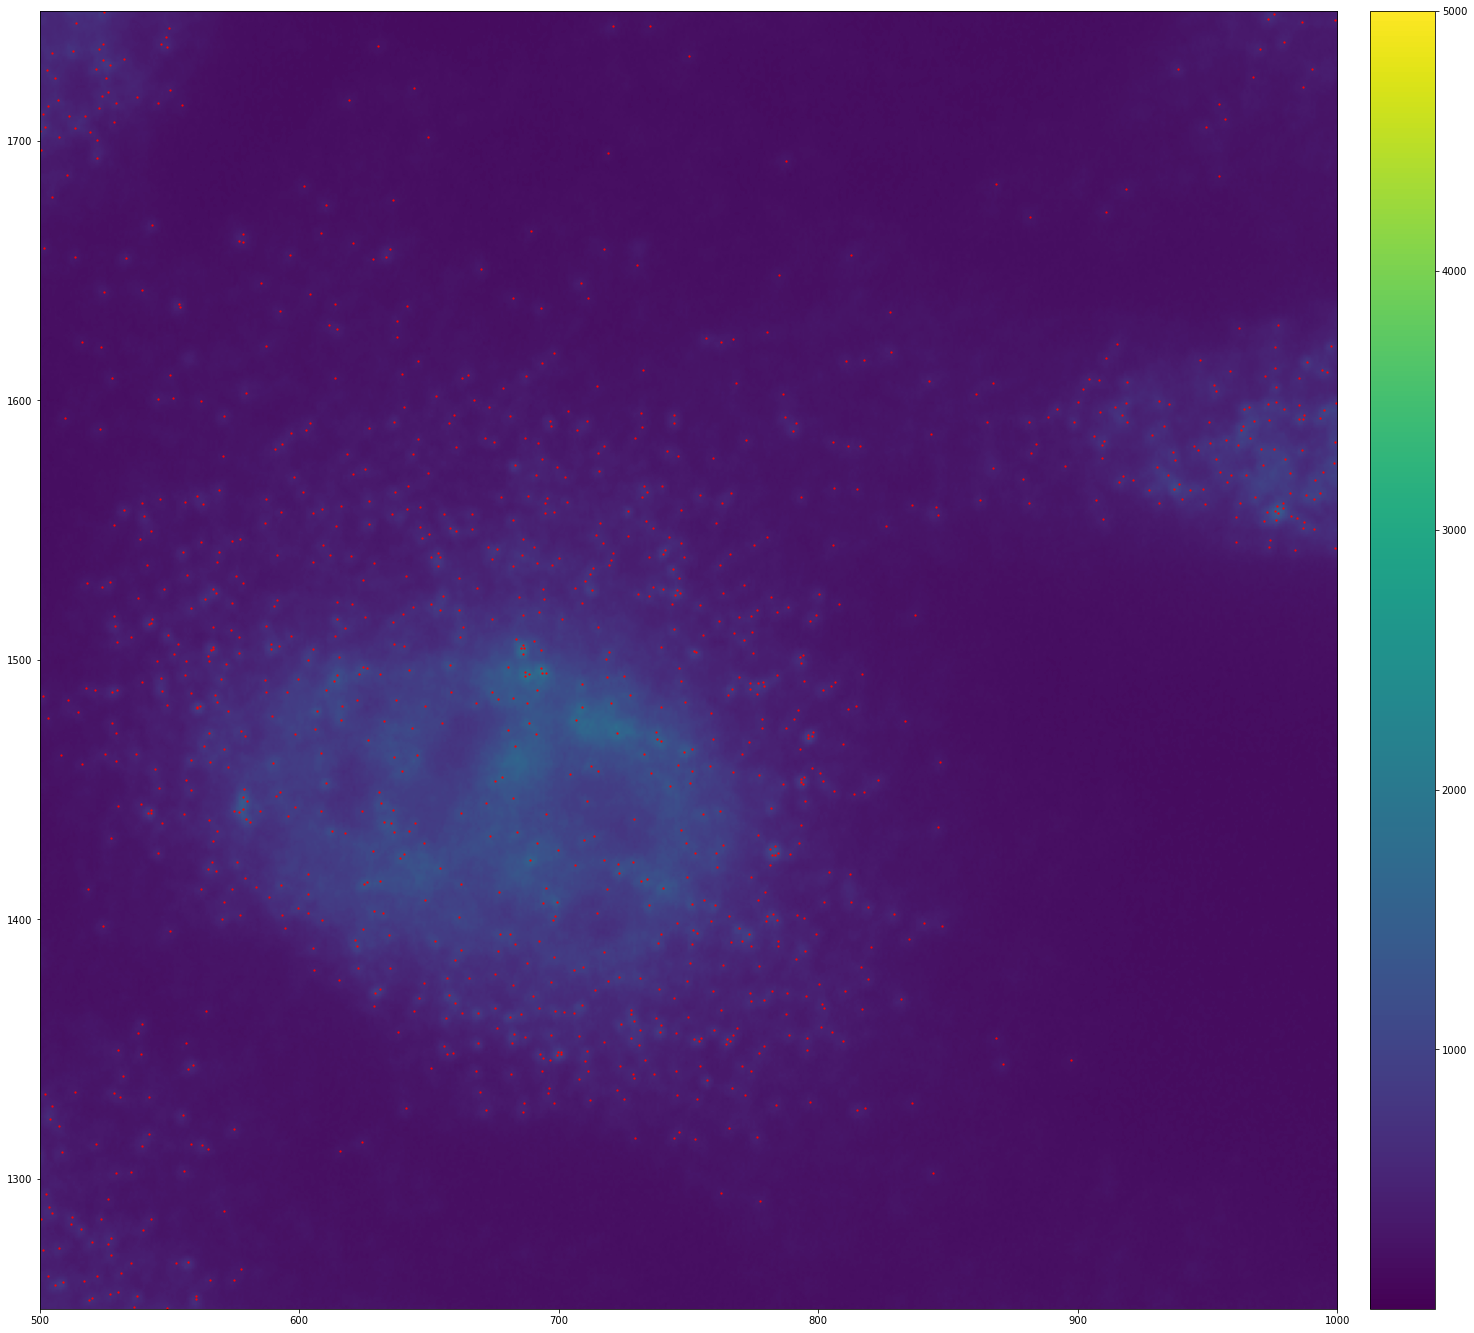

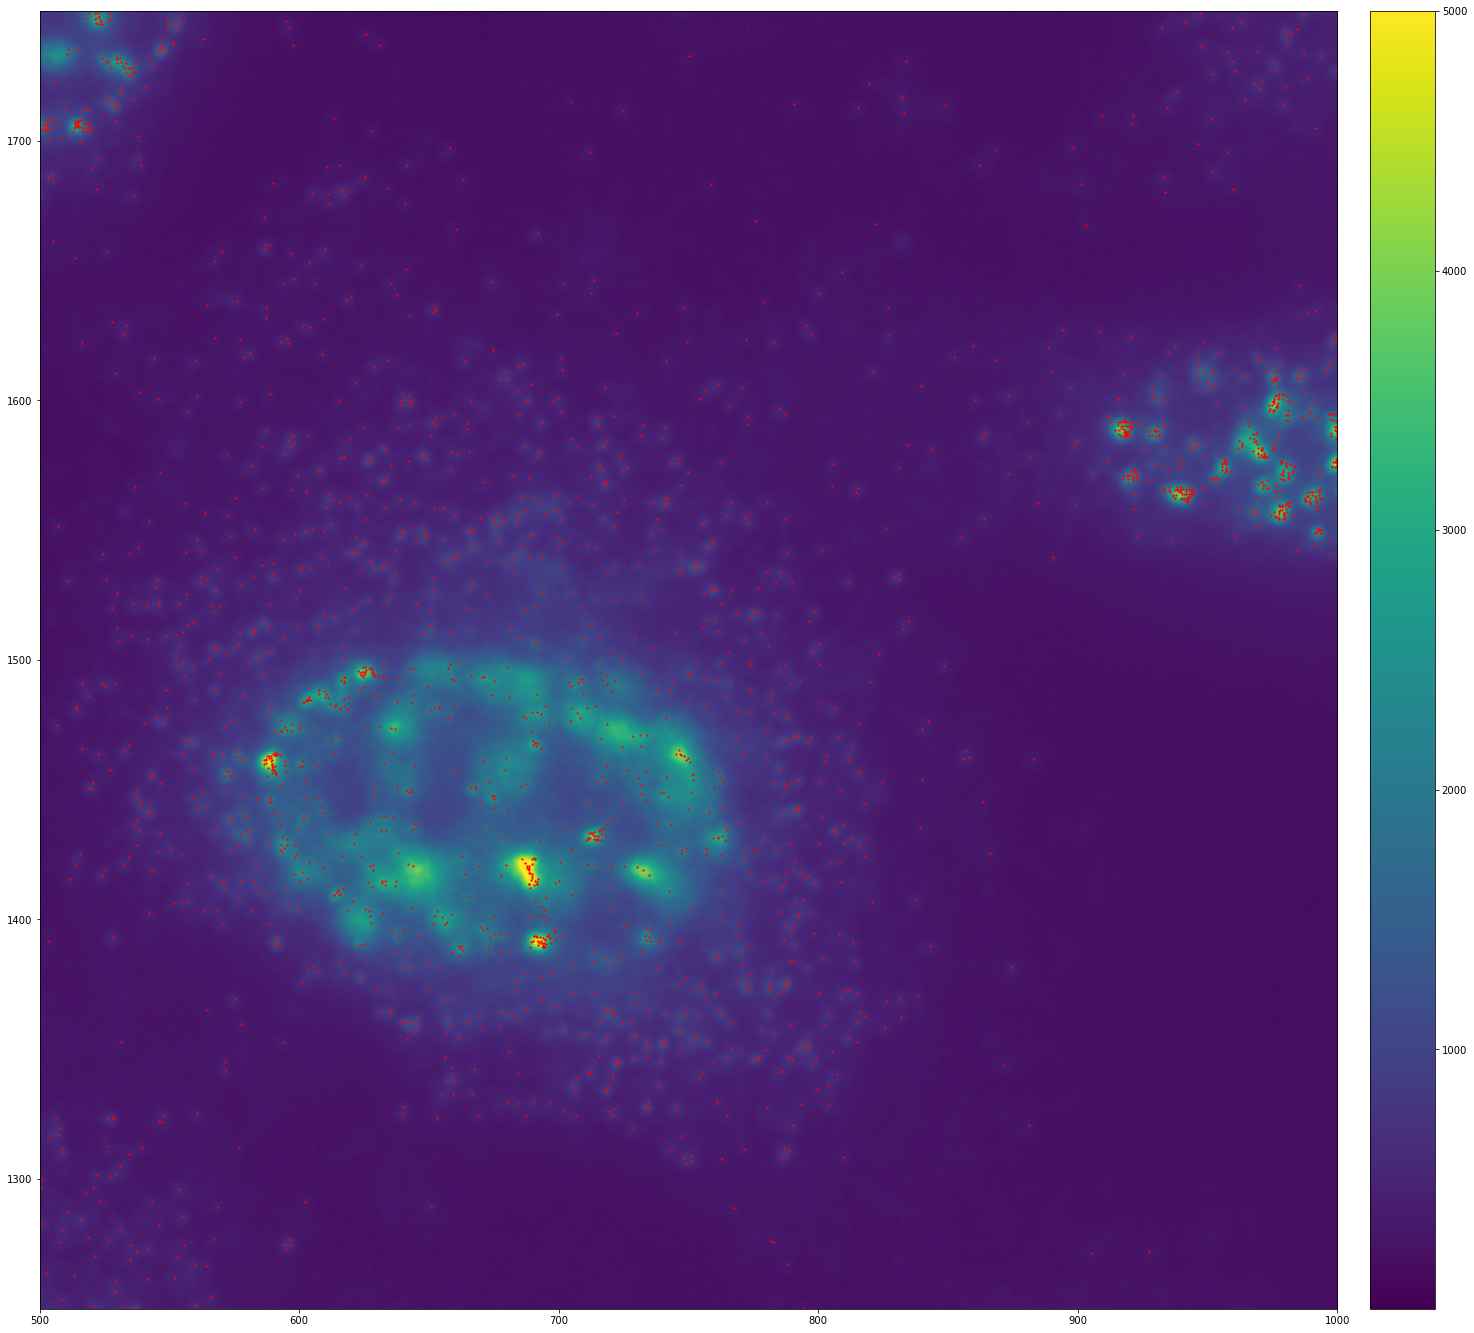

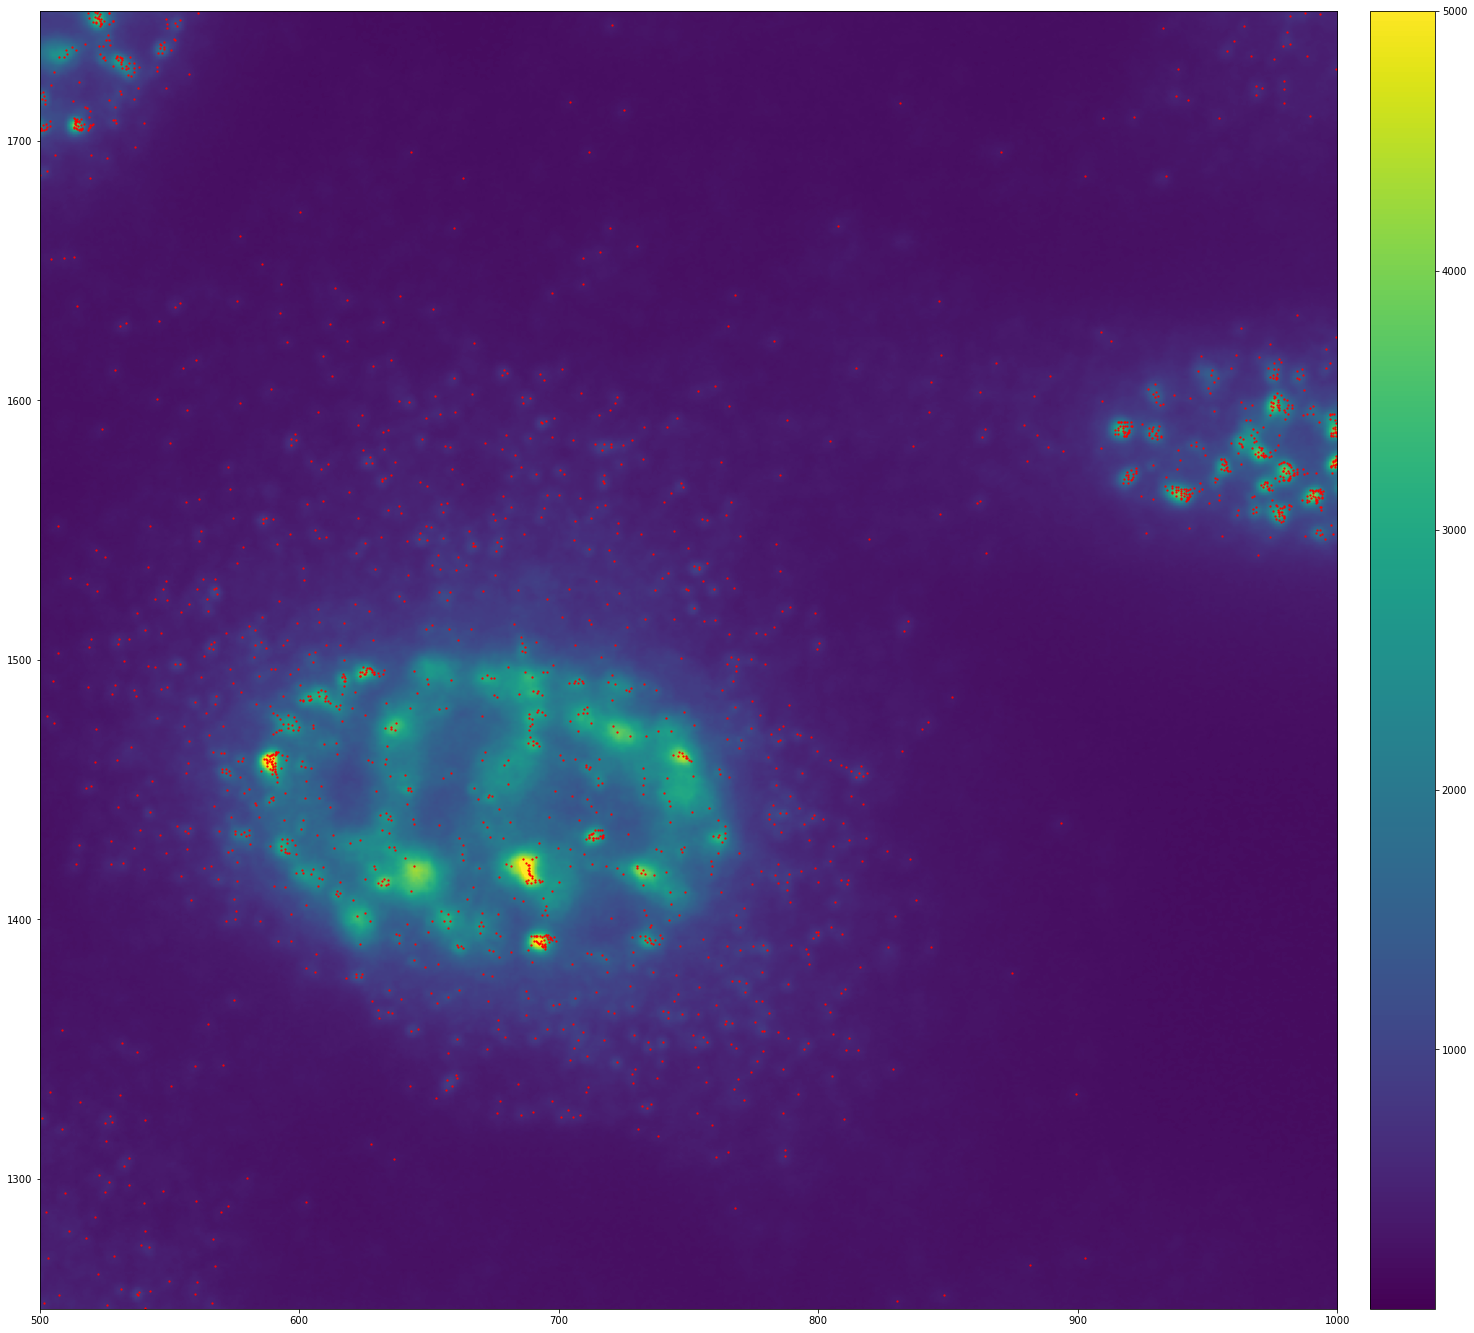

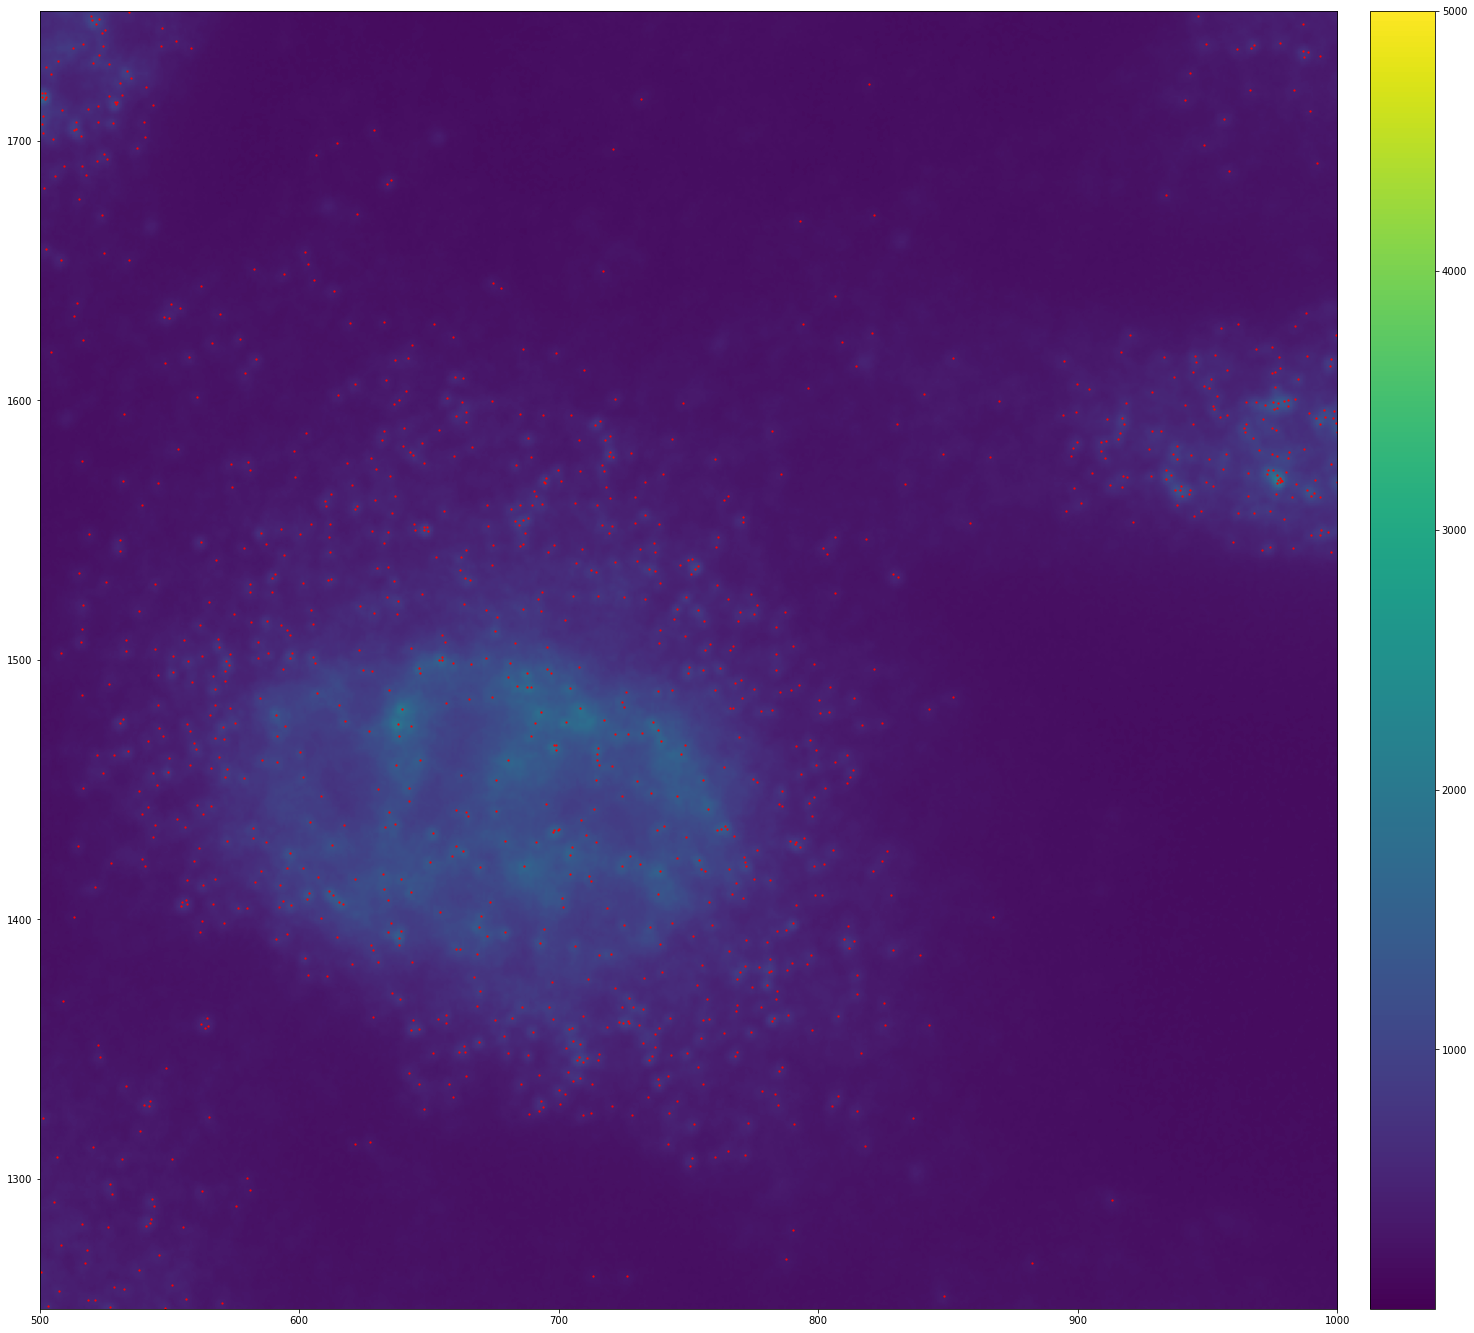

In [1873]:
for i in range(8):

    img = load_tiff_image(image_paths[i])
    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[cfg.data_path.sm_fish_ch,0], vmax=5000)
    add_colorbar(im)
    plt.xlim(500,1000)
    plt.ylim(1250,1750)

    plt.scatter(preds_px['x'],preds_px['y'], color='red', s=1.5)
    plt.show()